# Librerias

In [1]:
# Import functions from py scripts
from basic_functions import *
from bathymetry_functions import *

# Import librerias from python
import matplotlib as mpl
import datetime
import glob
import os
import matplotlib.dates as mdates
import mat73
from pytides2.tide import Tide
import pytides2.constituent  as cons
import pytides2.astro as astro
import matplotlib.pylab as pl
from scipy import signal
from pytz import timezone
import pytz
import missingno as msno
import mat73
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Personalizar graficas
plt.style.use("default")
mpl.rcParams['xtick.labelsize']=12
mpl.rcParams['ytick.labelsize']=12
mpl.rcParams['font.sans-serif'] = "Century Gothic"
mpl.rcParams['font.family'] = "Century Gothic"
mpl.rcParams['font.weight'] = 'normal'
def fig_params(ax):
    ax.grid()    
    ax.spines['left'].set_color('gray')
    ax.spines['right'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.spines['top'].set_color('gray')
    ax.tick_params('y', colors='tab:gray')
    ax.tick_params('x', colors='tab:gray')
    for label in ax.get_yticklabels():
        label.set_color('k')
        label.set_size(13)
    for label in ax.get_xticklabels():
        label.set_color('k')
        label.set_size(13)

import warnings
warnings.filterwarnings('ignore')

# Leer batimetría

Indices: 22, 15
Valor 1: 419840.873, Valor real 1: 419777.9967201181
Valor 2: 1388213.575, Valor real 2: 1388119.6799451713
Indices: 74, 80
Valor 1: 426340.873, Valor real 1: 426277.01849166275
Valor 2: 1393413.575, Valor real 2: 1393382.35178034


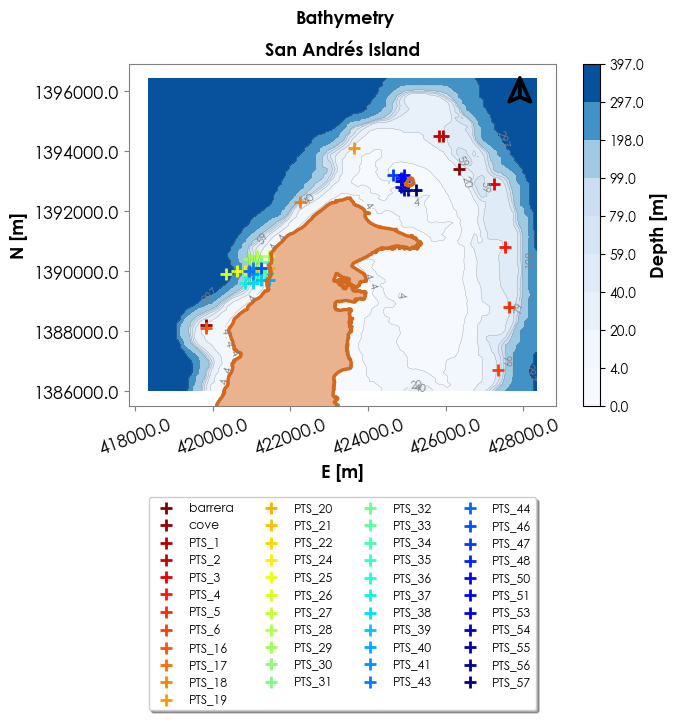

In [2]:
path = r'G:\My Drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\BATIMETRIA\BAT_NORTE_RECTANGULAR_100m'
name_file_grid = 'BAT_SAI_NORTE.grd'
name_file_deep = 'BAT_SAI_NORTE.dep'
name_file_coast = 'COAST_LINE.mat'
num_lineas = 21
n_rows = 106 #83
n_cols = 102

df_lc = read_coast_line (path= path, name_file = name_file_coast)
X, Y, Z = read_grid_file_d3d(num_btw_lines = num_lineas, ncols = n_cols, 
                             nrows = n_rows, path = path, name_file_grid = name_file_grid, name_file_deep = name_file_deep)
df_bat_sai = df_project_grid_grid(n_cols = n_cols, n_rows = n_rows, X= X, Y = Y)

lat_cove, lon_cove =  12.555738,-81.738463
x_cove, y_cove = proj_ZONE17(lon_cove,lat_cove)
lat_barrera, lon_barrera =  12.603483,-81.678766
x_barrera, y_barrera = proj_ZONE17(lon_barrera,lat_barrera)
try:
    ind_row, ind_col = min_ind_rotated_grid(value1=x_cove, vector1=X, value2= y_cove, vector2=Y, delta=100, view_coords = True)
    list_cove = ['cove', ind_col, ind_row]
    ind_row, ind_col = min_ind_rotated_grid(value1=x_barrera, vector1=X, value2= y_barrera, vector2=Y, delta=100, view_coords = True)
    list_barrera = ['barrera', ind_col, ind_row]
    if ((len(list_cove) > 0) & (len(list_barrera)>0)):
        dic_points = {'ID': [list_barrera[0], list_cove[0]], 'Ind_X': [list_barrera[1], list_cove[1]], 'Ind_Y': [list_barrera[2], list_cove[2]]}

except:
    try:
        ind_row, ind_col = min_ind_rotated_grid(value1=x_barrera, vector1=X, value2= y_barrera, vector2=Y, delta=100, view_coords = True)
        list_barrera = ['Barrera', ind_col, ind_row]
        if (len(list_barrera)>0): 
            dic_points = {'ID': [list_barrera[0]], 'Ind_X': [list_barrera[1]], 'Ind_Y': [list_barrera[2]]}

    except:
        ind_row, ind_col = min_ind_rotated_grid(value1=x_cove, vector1=X, value2= y_cove, vector2=Y, delta=100, view_coords = True)
        list_cove = ['Cove', ind_col, ind_row]
        if (len(list_cove) > 0): 
            dic_points = {'ID': [list_cove[0]], 'Ind_X': [list_cove[1]], 'Ind_Y': [list_cove[2]]}


df_ind = obs_DataFrame (path = 'G:\My Drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\ESCENARIOS', 
                        name_file = 'Coordenas_Perfiles.csv', dic_points_plus = dic_points, X = X, Y = Y)
bat_figure(df_lc= df_lc,X= X, Y= Y, Z=Z[:-1,:-1], delta_lim= 500,delta = 450, 
           size = (7.,8 ), active_puntos_obs = True ,df_ind = df_ind, bottom_legend = -0.25)

# bat_figure(df_lc= df_lc,X= X, Y= Y, Z=Z[:-1,:-1], delta_lim= 500,delta = 450 ,size = (8, 6), active_puntos_obs = False)

# Periodo de modelación

In [3]:
def wavelength(T,h):
    '''
    Función para determinar la longitud de ola
    -----------
    Parametros de entrada
    T: Periodo de ola 
    h: Profunidad
    -----------
    Returns: 
    L1: Longitud de ola
    '''
    #Función que calcula L en aguas intermedias
    Lo = (9.81*T**2)/(2*np.pi);
    L1  = (9.81*T**2)/(2*np.pi)*np.tanh((h*2*np.pi)/Lo);
    i = 0;
    while (abs(Lo-L1)>0.0001):
        Lo = L1;
        L1  = (9.81*T**2)/(2*np.pi)*np.tanh(h*2*np.pi/Lo);
        i = i+1;
        if (i>5000):
            break
    return (L1)

def celeridad_grupo(T:float, h:float) -> float:
    """Función para determinar la celeridad de las olas

    Parameters
    ----------
    T : float
        Periodo
    h : float
        Profunidad
    Returns
    -------
    float
        Cg: celeridad de grupo de las olas
    """

    k = 2*np.pi/wavelength(T,h)
    angular_frec = 2*np.pi/T
    Cg = (1/2)*(1+ (2*k*h/(np.sinh(2*k*h))))*(angular_frec/k)
    return Cg

In [4]:
periodo = 6 # segundos
h = 400 # metros
dist_coast = 4000 # metros
w_length = wavelength(periodo, h) # metros
Cg = celeridad_grupo(periodo, h) # metros/segundos
time_prop = (dist_coast/Cg)/60 # minutos
print(f'Longitud de onda: {w_length}')
print(f'Celeridad de grupo: {Cg}')
print(f'Tiempo de propagación en minutos: {time_prop}')

Longitud de onda: 56.20715970233376
Celeridad de grupo: 4.68392997519448
Tiempo de propagación en minutos: 14.233062197711147


# Pluma del trazador

In [5]:
def time_matlab (vec_time:float):
    """
    Función para obtener los tiempos en formato datetime 
    ----------------------------------------------------
    Input: 
    - vec_time: vector de tiempos en formato matlab
    ----------------------------------------------------
    - time: lista con los tiempos en formato datetime
    """
    time = []
    for time_i in vec_time:
        py_time = datetime.datetime.fromordinal(int(time_i)) + datetime.timedelta(days=time_i%1) - datetime.timedelta(days = 366)
        py_time = py_time +datetime.timedelta(microseconds=3)
        py_time = datetime.datetime(py_time.year, py_time.month, py_time.day, py_time.hour, py_time.minute, py_time.second)
        time.append(py_time)
    return time

def read_map_mat73_file(path,name_file):
    """Esta función lee archivos .mat 
    -----------------------------------
    Input:
    - path: ruta del archivo a leer
    - name_file: nombre del archivo 
    -----------------------------------
    Output: 
    - time_model: vector de tiempos 
    - dic_: diccionario de las variables """
    data = mat73.loadmat(f'{path}\{name_file}')
    dic_ = data['data']
    time_model = time_matlab (vec_time = dic_['Time'])
    return time_model, dic_


def figure_tracer(zone:str, dic_vel:dict, dic_tracer:dict ,df_lc:pd.DataFrame, time_ind:int, time_model:datetime.datetime, slide:int
                , colormap:cm, size:tuple,min_percen:float, max_percen:float, min_level:float, max_level,delta:float, quiver_scale:float, 
                quiver_lenght:float,set_limits:bool,active_tracker:bool,active_puntos_obs:bool,
                list_lims_X:list= None,list_lims_Y:list= None,df_track:pd.DataFrame = None,
                 time_ini_track:datetime.datetime = None ,df_ind = None, bottom_legend = None):
    """_summary_

    Parameters
    ----------
    zone : str
        Zona donde se evalúa el trazador
    dic_vel : dict
        Diccionario del campo del velocidades
    dic_tracer : dict
        Diccionario del campo del trazador
    df_lc : pd.DataFrame
        Data frame de la linea de costa
    time_ind : int
        Indice del tiempo a pintar
    time_model : datetime.datetime
        Tiempo que corresponde al indice a pintar
    slide : int
        Cantidad de vectores en el campo de velocidades (menos valores más vectores)
    colormap : cm
        Paleta de colores de colormap
    size : tuple
        Tamaño de la imagen
    min_percen : float
        minimo porcentaje del trazador para resaltar con lineas
    max_percen : float
        maximo porcentaje del trazador para resaltar con líneas
    min_level : float
        minimo valor de los bins para graficar el contourf
    max_level : _type_
        máximo valor de los bins para graficar el contourf
    delta : float
        Valor en metros para posicionar los campos
    quiver_scale : float
        valor para configurar la escala de las arows 
    quiver_lenght : float
        valor para configirar la longitud de las arows
    set_limits : bool
        - True para escalar la zona de interes
        - False para ver toda el área
    active_tracker : bool
        - True para observar el rastreador de particulas
        - False para ignorarlo
    active_puntos_obs : bool
        - True para activar los puntos de observación en la isla
        - False para no observar los puntos de observación
    list_lims_X : list, optional
        Si se activa "set_limits" se debe escribir los limites X, by default None
    list_lims_Y : list, optional
        Si se activa "set_limits" se debe escribir los limites Y, by default None
    df_track : pd.DataFrame, optional
        Data farame del rastreador, by default None
    time_ini_track : datetime.datetime, optional
        fecha de inicio para observar la posición del rastreador de particulas, by default None
    df_ind : _type_, optional
        data frame de los puntos de observación by default None
    bottom_legend : _type_, optional
        Posición de la leyenda debajo del tick del eje X (si es más pequeño se acerca al tick), by default None 
    """

    # # Librerías
    # import matplotlib.ticker as mticker

    u = dic_vel['XComp'][time_ind,:,:]
    v = dic_vel['YComp'][time_ind,:,:]
    for i, j in zip (np.where(np.isnan(Z)==True)[0], np.where(np.isnan(Z)==True)[1]):
        u[j, i] = np.nan
        v[j, i] = np.nan        

    x = dic_vel['X'][:,:]
    y = dic_vel['Y'][:,:]
    vel = np.sqrt(u**2+v**2)
    Y_model = y[:,:][::slide, ::slide]
    X_model = x[:,:][::slide, ::slide]
    U = u[::slide,::slide]
    V = v[::slide,::slide]
    tracer = dic_tracer['Val'][time_ind,:,:]
    for i, j in zip(np.where(np.isnan(Z)==True)[0], np.where(np.isnan(Z)==True)[1]):
        tracer [j,i] = np.nan 
       
    # max_level = np.nanmax(vel)
    fig, ax = plt.subplots(figsize = size)
    ax.set_facecolor('lightcyan')
    levels = list(np.round(np.linspace(min_level, max_level, 20), 5))
    pc = ax.contourf(dic_tracer['X'][:-1, :-1, 0], dic_tracer['Y'][:-1, :-1,0], tracer,levels = levels,cmap = colormap)
    cb=plt.colorbar(pc)
    levels_contour = [ min_level, max_level*max_percen/100]
    a = ax.contour(dic_tracer['X'][:-1, :-1, 0], dic_tracer['Y'][:-1, :-1,0], tracer,levels=levels_contour,colors=["aqua", 'red'],
                    linewidths=2)
    h_, l1 = a.legend_elements()

    ax.set_xlabel ('E [m]',size=16, fontweight = 'semibold')
    ax.set_ylabel ('N [m]',size=16, fontweight = 'semibold')


    ax.plot(df_lc['X'], df_lc['Y'], "-",c='chocolate', lw=2.5, alpha = 1)
    ax.fill_between(df_lc['X'], df_lc['Y'], color='sandybrown', alpha=0.7, linewidth=0)
    brujula_path, attributes = svg2paths('brujula.svg')
    brujula_marker = parse_path(attributes[0]['d'])
    brujula_marker.vertices -= brujula_marker.vertices.mean(axis=0)
    brujula_marker = brujula_marker.transformed(mpl.transforms.Affine2D().rotate_deg(0))
    brujula_marker = brujula_marker.transformed(mpl.transforms.Affine2D().scale(-1,1))

    cb.set_label('Tracer concentration [kg/m3]',size=15, fontweight = 'semibold')
    fig_params(ax)
    ax.set_title(f'Tracer in {zone} at {str(time_model)}',size = 16,fontweight = 'semibold')
    q = ax.quiver(X_model,Y_model,U,V,color='k',alpha=0.5, scale = quiver_scale)

    if set_limits == True: 
        ax.set_xlim(list_lims_X)
        ax.set_ylim(list_lims_Y)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=35)
        ax.quiverkey(q,0.85,0.035,quiver_lenght,label = r'1 m/s',coordinates='figure',fontproperties={'size':10})
        ax.scatter(max(list_lims_X)-delta, max(list_lims_Y)-delta, marker= brujula_marker, color = 'k', s = 8**3)
    elif set_limits == False:
        ax.set_xlim([np.nanmin(x)- delta, np.nanmax(x)+ delta])
        ax.set_ylim([np.nanmin(y)- delta, np.nanmax(y)+ delta])
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.quiverkey(q,0.8,0.05,quiver_lenght,label = r'1 m/s',coordinates='figure',fontproperties={'size':10})
        ax.scatter(X.max()-delta, Y.max()-delta, marker= brujula_marker, color = 'k', s = 8**3)

    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    if active_tracker == True:
        df_track = df_track[time_ini_track: time_model]
        plot_track, = ax.plot(df_track['X'], df_track['Y'], c = 'm',ls = '--', lw = 1.5)
    if active_puntos_obs == True:
        colors = mpl.cm.jet_r(np.linspace(0,1,len(df_ind)))
        k = 0
        for col, row in zip (df_ind['Ind_X'], df_ind['Ind_Y']):
            ax.scatter(X[row, col], Y[row, col], marker = '+', color = colors[k], label = df_ind['ID'][k], s = 8**2, lw = 2)
            k = k+1
        _= ax.legend(loc='upper center', bbox_to_anchor=(0.5, bottom_legend),
                fancybox=True, shadow=True, ncol=4, fontsize = 9)
    elif active_puntos_obs == False:
        # _=fig.legend(loc='upper center', bbox_to_anchor=(0.5, bottom_legend),
        #         fancybox=True, shadow=True, ncol=4, fontsize = 9)
        _=ax.legend([h_[0], h_[1], plot_track], [f'{min_percen}%', f'{max_percen}%', 'Tracker'], loc='upper center', bbox_to_anchor=(0.5, bottom_legend),
        fancybox=True, shadow=True, ncol=4, fontsize = 11)

    # plt.xticks(rotation =22.5)
    plt.grid(False)
    return

In [6]:
path = r'G:\My Drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\ESCENARIOS\ESCENARIOS_PRUEBA\PRUEBA_2'
name_file_trazador = r'Trazador\tracer_Emmisary.mat'
time_model, dic_tracer = read_map_mat73_file(path= path, name_file= name_file_trazador)

path = r'G:\My Drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\ESCENARIOS\ESCENARIOS_PRUEBA\PRUEBA_2'
name_file_velocity = r'Velocity\depth_averaged_velocity.mat'
time_model, dic_velocity = read_map_mat73_file(path= path, name_file= name_file_velocity)

In [7]:
path = r'G:\My Drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\ESCENARIOS\ESCENARIOS_PRUEBA\PRUEBA_2'
name_file_track = 'drogue_track_Emissary.mat'
time_model_track, dic_track = read_map_mat73_file(path= path, name_file= name_file_track)
df_track = pd.DataFrame({'time':time_model_track, 'X': dic_track['X'], 'Y': dic_track['Y']}).set_index('time')

In [1]:
time_ind = 130
min_percen = 2
max_percen = 10
figure_tracer(zone = 'Emissary', dic_vel = dic_velocity, dic_tracer= dic_tracer , 
                df_lc= df_lc, time_ind = time_ind, time_model = time_model[time_ind], 
                slide = 3, colormap= cm.YlOrRd, size = (8, 6), 
                min_percen = min_percen, max_percen = max_percen, 
                min_level = np.nanmax(dic_tracer['Val'][time_ind,:,:])*min_percen/100,
                max_level= np.nanmax(dic_tracer['Val'][time_ind,:,:]),
                quiver_scale= 10, quiver_lenght= 0.6, delta = 500,
                set_limits= False, active_tracker = True,active_puntos_obs = False, df_track = df_track, 
                time_ini_track = df_track.index[0],
                df_ind = df_ind, bottom_legend = -0.25)

NameError: name 'figure_tracer' is not defined

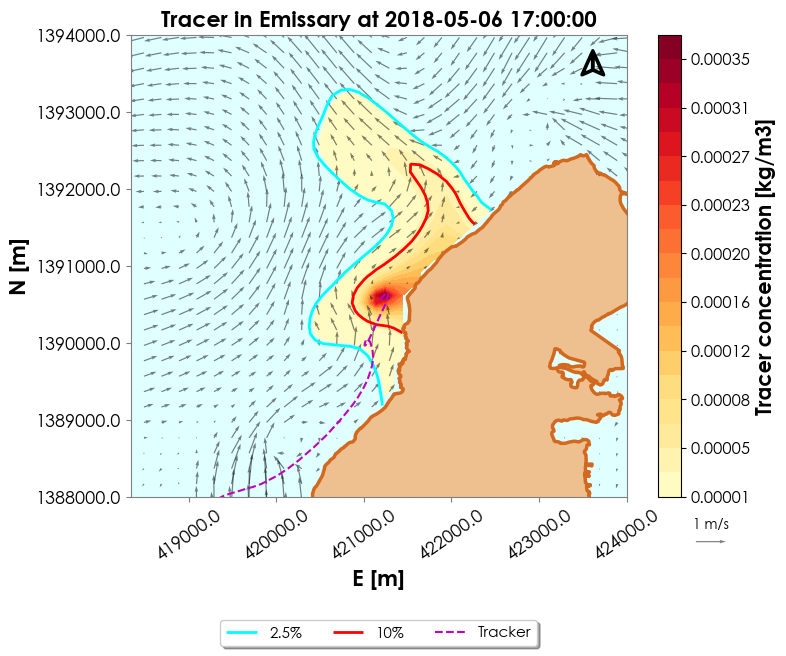

In [11]:
time_ind = 130
min_percen = 2.5
max_percen = 10
figure_tracer(zone = 'Emissary',dic_vel = dic_velocity, dic_tracer= dic_tracer , 
                df_lc= df_lc, time_ind = time_ind, time_model = time_model[time_ind], 
                slide = 2, colormap= cm.YlOrRd, size = (8, 6),
                min_percen = min_percen, max_percen = max_percen, 
                min_level = np.nanmax(dic_tracer['Val'][time_ind,:,:])*min_percen/100,
                max_level= np.nanmax(dic_tracer['Val'][time_ind,:,:]),
                quiver_scale= 10, quiver_lenght= 0.6, delta = 400,
                set_limits= True, active_tracker = True ,active_puntos_obs = False,
                list_lims_X = [np.nanmin(X),424000],list_lims_Y= [1388000, 1394000],  
                df_track = df_track, time_ini_track = df_track.index[0]  
                ,df_ind = df_ind, bottom_legend = -0.25)